In [1]:
!python -m pip install gwpy
!pip install astropy==4.2.1


     |████████████████████████████████| 1.4 MB 767 kB/s            
     |████████████████████████████████| 51 kB 4.9 MB/s             
  Preparing metadata (setup.py) ... - \ done
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp37-cp37m-linux_x86_64.whl size=99647 sha256=9655ea912f6111ab2fa430514651210906c4a3402ee8198c13e21d9129f0fbab
  Stored in directory: /root/.cache/pip/wheels/09/f9/d4/129b3bb4458d50b56fdc8245ace7c8216d54865fe8d3aebc05
Successfully built ligo-segments
     |████████████████████████████████| 9.7 MB 775 kB/s            
  Attempting uninstall: astropy
    Found existing installation: astropy 4.3.1
    Uninstalling astropy-4.3.1:
      Successfully uninstalled astropy-4.3.1


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
import matplotlib.axes as ax
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split



from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from matplotlib import pyplot as plt

# Load Data

In [3]:
train_label = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
train_label.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


<AxesSubplot:xlabel='target', ylabel='count'>

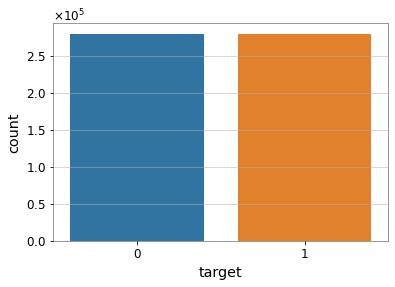

In [4]:
sns.countplot(data=train_label, x="target")

In [5]:
train_label['target'].value_counts()

0    280070
1    279930
Name: target, dtype: int64

amount of data for gravitational wave and non gravitational wave is equal

In [6]:
train_label.isnull().sum()

id        0
target    0
dtype: int64

In [7]:
train_path = glob('../input/g2net-gravitational-wave-detection/train/*/*/*/*')

In [8]:
#getting ID
def get_id(index):
    '''args:
            index=number of index
        returns: path of data based on the index'''
    rind = train_path[index].rindex('/') # last index where the character '/' appeared
    path=train_path[index][rind+1:].replace('.npy','') 
    return path

#adding train_path into train dataframe
ids = []
for i in range(len(train_path)):
    ids.append(get_id(i))
train= pd.DataFrame({"id":ids,"path":train_path})
train = pd.merge(train, train_label, on='id')
train.head()

,id,path,target
0,777d746e90,../input/g2net-gravitational-wave-detection/tr...,1
1,777ecfbd65,../input/g2net-gravitational-wave-detection/tr...,0
2,7770956992,../input/g2net-gravitational-wave-detection/tr...,1
3,77727f6826,../input/g2net-gravitational-wave-detection/tr...,1
4,777c84c377,../input/g2net-gravitational-wave-detection/tr...,0


# EDA

Visualize the data

In [9]:
def read_file(fname):
    data = np.load(fname)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
    return d1, d2, d3

def plot_time_data(d1, d2, d3):
    plot = Plot(d1, d2, d3, separate=True, sharex=True, figsize=[12, 8])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plot.show()

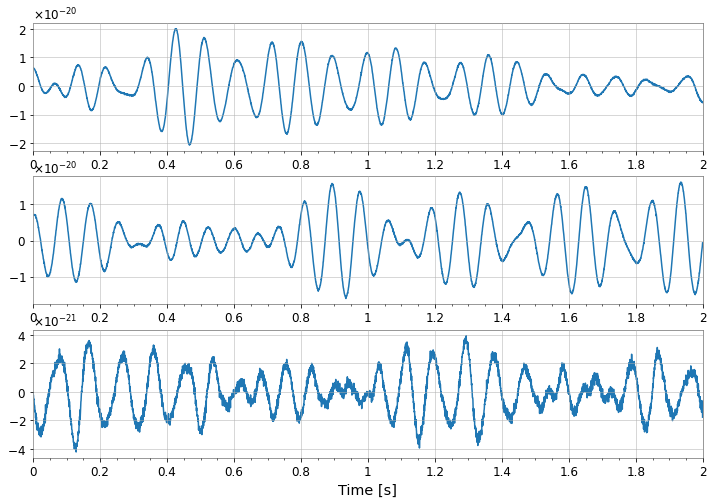

In [10]:
index = np.random.randint(1, len(train))
d1, d2, d3 = read_file(train['path'][index])
plot_time_data(d1, d2, d3)

# Preprocess

Then we will follow the general processing steps outlined in this article:

*     Apply a window function (Tukey - tapered cosine window) to suppress spectral leakage
*     Whiten the spectrum
*     Bandpass




# Apply window function

The Tukey window looks like this:


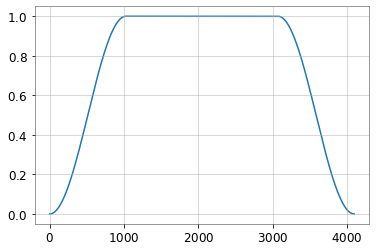

In [11]:
window = signal.tukey(4096)
plt.plot(window);

signal after windowed

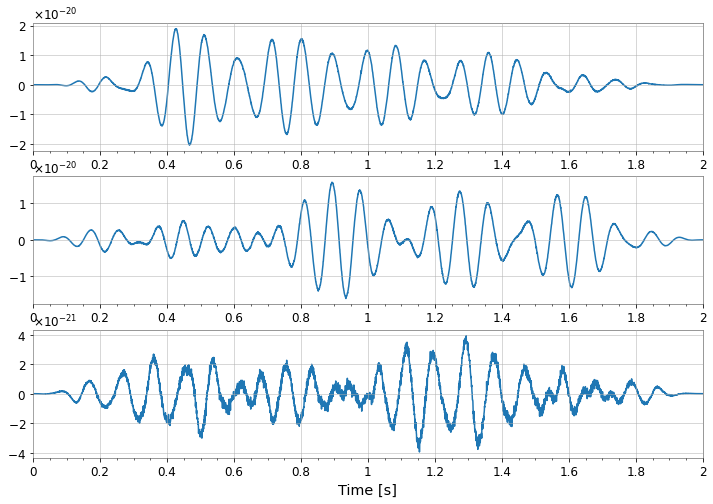

In [12]:
d1, d2, d3 = d1*window, d2*window, d3*window
plot_time_data(d1, d2, d3)

Take a look at the spectrum - there is a lot of low frequency noise:

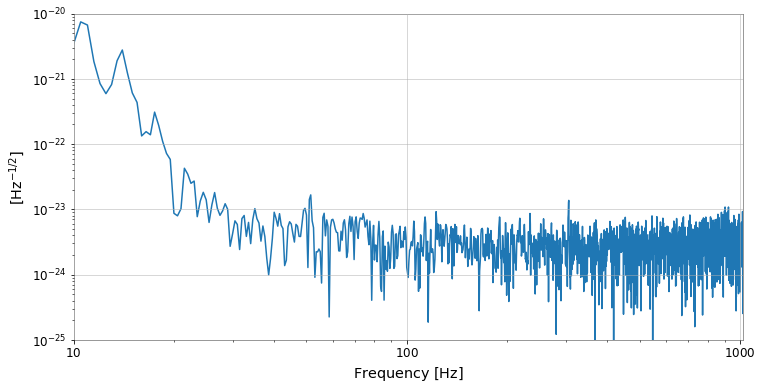

In [13]:
fig2 = d1.asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

We can easily highpass the data (here with 15Hz highpass frequency):

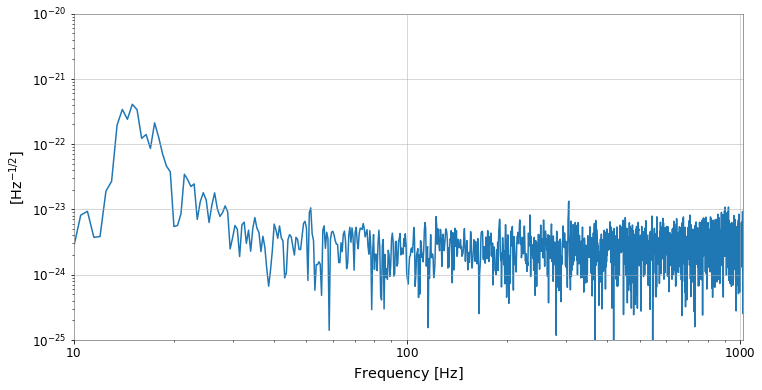

In [14]:
fig2b = d1.highpass(15).asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);


# Spectral whitening and bandpass filtering

This is super simple with GWpy:

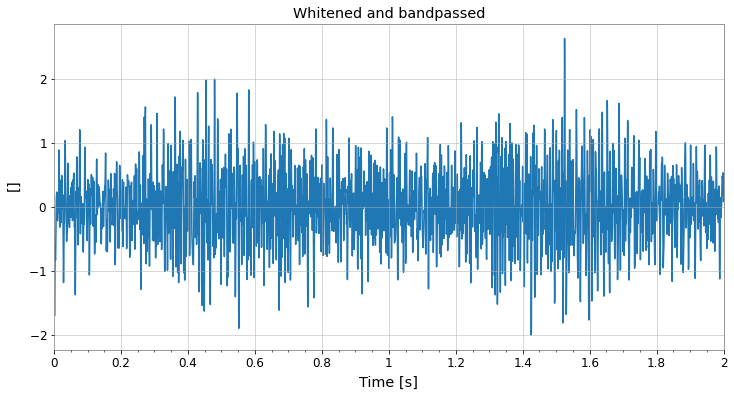

In [15]:
white_data = d1.whiten(window=("tukey",0.2)) # whiten-function has a built-in window function
bp_data = white_data.bandpass(35, 350) # frequency range 35-350Hz
fig3 = bp_data.plot(figsize=[12, 6])
plt.xlim(0, 2)
ax = plt.gca()
ax.set_title('Whitened and bandpassed')
ax.set_xlabel('Time [s]');

Now, we have a preprocessed data that is ready for further analysis. First, let's define a function that combines all the steps above and outputs preprocessed data:

In [16]:
def preprocess(d1, d2, d3, bandpass=False, lf=35, hf=350):
    white_d1 = d1.whiten(window=("tukey",0.2))
    white_d2 = d2.whiten(window=("tukey",0.2))
    white_d3 = d3.whiten(window=("tukey",0.2))
    if bandpass: # bandpass filter
        bp_d1 = white_d1.bandpass(lf, hf) 
        bp_d2 = white_d2.bandpass(lf, hf)
        bp_d3 = white_d3.bandpass(lf, hf)
        return bp_d1, bp_d2, bp_d3
    else: # only whiten
        return white_d1, white_d2, white_d3


# Q-Transform

The Q-Transform is related to the Fourier transform, and very closely related to a wavelet transform. The spectrogram is a possible candidate as input for a CNN model.


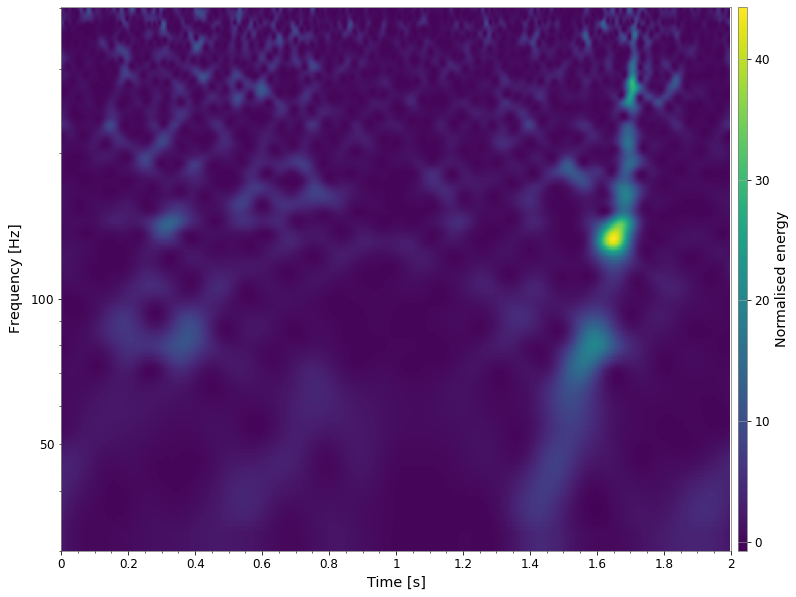

In [17]:
r1, r2, r3 = read_file('../input/g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy') # this signal has target=1
p1, p2, p3 = preprocess(r1, r2, r3)
hq = p2.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False)
fig4 = hq.plot(figsize=[12, 10])
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Time [s]');


# Combine three channels into one RGB image

Since we have 3 detectors, we can combine the Q-Transforms as RGB channels into one color image. Let's make a function for that:


In [18]:
Q_RANGE = (16,32)
F_RANGE = (30,400)

def create_rgb(fname):
    r1, r2, r3 = read_file(fname)
    p1, p2, p3 = preprocess(r1, r2, r3)
    hq1 = p1.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq2 = p2.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq3 = p3.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    img = np.zeros([hq1.shape[0], hq1.shape[1], 3], dtype=np.uint8)
    scaler = MinMaxScaler()
    img[:,:,0] = 255*scaler.fit_transform(hq1)
    img[:,:,1] = 255*scaler.fit_transform(hq2)
    img[:,:,2] = 255*scaler.fit_transform(hq3)
    return Image.fromarray(img).rotate(90, expand=1).resize((760,760))

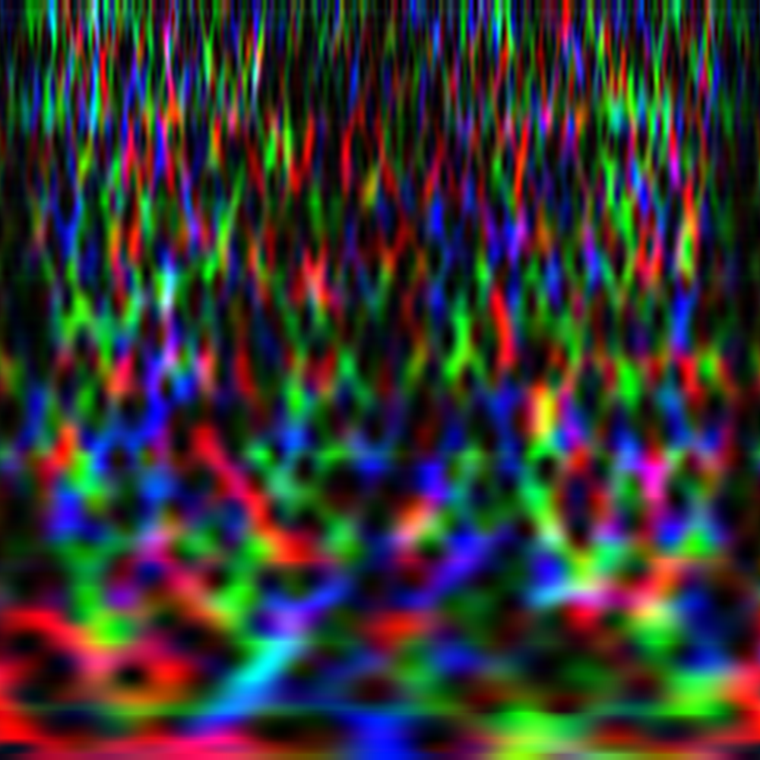

In [19]:
create_rgb(train['path'][index])

# Preparing Dataset

In [20]:
def grouping_slicing(data, target, num_start, num_end):
    #grouping data frame based on target
    _data=data[data['target']==target]
    
    #slicing data into 300
    _data=_data[num_start:num_end]
    
    #reset index
    _data=_data.reset_index(drop=True)
    return _data
grav=grouping_slicing(train, target=1,num_start=0, num_end=600)
nongrav=grouping_slicing(train, target=0, num_start=0, num_end=600)

In [21]:
grav.shape

(600, 3)

In [22]:
#split into train and validation
#train
train_grav=grav[0:350]
train_nongrav=nongrav[:350]
#validation
valid_grav=grav[350:500]
valid_nongrav=nongrav[350:500]
#testing
test_grav=grav[500:600]
test_nongrav=nongrav[500:600]

In [23]:
def get_path_name(data,index):
    '''args:
            index=number of index
        returns: path of data based on the index'''
    rind = data['path'][index].rindex('/') # last index where the character '/' appeared
    path=train_path[index][rind+1:].replace('.npy','') 
    return path

def saving_image(data, folder,folder_name):
    '''function to generate graph and saving it into jpg
    
    input:
        data: frame that we want to convert into image
            example: convert file name in the path
        folder: the folder for train or test or validation
        folder_name : the folder for grav and non grav
    output:
        jpg extention
    '''
    for path in data['path']:
        file=np.load(path)
        i=data[data['path']==path].index.values.astype(int)[0]#to get index of the path
        ID=get_path_name(data,i)#get path name
        #creating graphic
        image=create_rgb(path)
        image.save('{}_{}_{}.png'.format(folder,folder_name,ID))

    #fig.suptitle(f"Q transform visualization. ID: {file_id}. Target: {target}.", fontsize=16)
        
    print('{} has been generate images complete!'. format(folder))

In [24]:
#generate train data
saving_image(train_grav, 'train', 'grav')
saving_image(train_nongrav,'train', 'nongrav')

#generate validation data
saving_image(valid_grav,'validation', 'grav')
saving_image(valid_nongrav,'validation', 'nongrav')

#generate test data
saving_image(test_grav,'test', 'grav')
saving_image(test_nongrav,'test', 'nongrav')

train has been generate images complete!
train has been generate images complete!
validation has been generate images complete!
validation has been generate images complete!
test has been generate images complete!
test has been generate images complete!
